## makemore: becoming a backprop ninja

In [ ]:
# there no change change in the first several cells from last lecture

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# ok biolerplate done, now we get to the action:

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani # x-u
bndiff2 = bndiff**2 
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) || variance, sigma^2
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv # x_hat
hpreact = bngain * bnraw + bnbias # y
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv ## just normalising, counts / counts.sum(1, keepdims=True)
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3505, grad_fn=<NegBackward0>)

In [13]:
logprobs.shape
print(logprobs)
# Remember how the loss thing works.
# -ve, logprobs[range(n), Yb]

tensor([[-2.5823, -2.4418, -3.9060, -2.9445, -3.8890, -2.4887, -3.8025, -3.2968,
         -4.0800, -3.4857, -3.3812, -3.2194, -3.2987, -3.5811, -3.3887, -4.2905,
         -4.6760, -4.0194, -4.1200, -2.9517, -2.8796, -3.8509, -3.6637, -2.6481,
         -2.9210, -3.7308, -3.8813],
        [-2.8827, -2.8315, -2.3772, -2.8874, -3.3825, -3.3425, -4.0167, -3.1033,
         -3.9158, -3.7564, -3.0263, -3.0858, -3.0230, -3.5847, -3.1128, -3.2339,
         -3.7269, -4.0585, -3.8210, -3.2742, -3.9461, -3.7605, -4.1638, -2.7460,
         -3.7331, -3.3271, -3.7580],
        [-3.9332, -3.7268, -4.2446, -4.2858, -3.7491, -3.0247, -2.8519, -2.7813,
         -2.9234, -3.4812, -3.9108, -3.3292, -3.1411, -3.1314, -3.7879, -3.6449,
         -4.2508, -3.3705, -3.4712, -2.2120, -2.6279, -3.3457, -3.2258, -3.2448,
         -3.2663, -3.9618, -3.5794],
        [-3.3769, -3.5979, -3.1605, -2.9654, -2.8066, -3.4942, -3.0652, -3.2225,
         -3.0245, -4.0125, -3.2722, -3.5754, -3.4202, -3.1971, -2.8591, -2.7222

In [12]:
print(Yb)
## All this bit is doing is going down each row, and then selecting the Yb'th column from that row, and then returning that
print(logprobs[range(n), Yb]) #Right?

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])
tensor([-4.0800, -3.1128, -3.6449, -3.2669, -4.1298, -3.5619, -3.1386, -3.9707,
        -3.0842, -4.2837, -3.1102, -1.6542, -2.9209, -2.9825, -3.0135, -3.1200,
        -3.8248, -2.8919, -3.6768, -3.3330, -2.8586, -2.8881, -4.3195, -4.0140,
        -3.5558, -2.8390, -2.9796, -3.8694, -2.6990, -3.4527, -3.2730, -3.1016],
       grad_fn=<IndexBackward0>)


In [ ]:
# And then our loss is just meaning the above, and then -ve it. 
# e.g loss = - (a+b+c)/3 = -1/3a + -1/3b + -1/3c for a 3 example thing sooo that means
# something like dloss/da = -1/3, etc... I.e it'd all be -1/3 for that 3 num example.
# So that means dloss/da (or any element in our selected logprobs this case) would be -1/num(elements in logprobs[range(n), Yb]) = -1/n in this case
# And intuitively, the logprobs not in the selected range would have a 0 gradient because changing them wouldn't affect the loss :P (in this batch, so they have a 0 gradient here).

Okay, so dprobs... dL/dprobs, right? Well, we'll be doing the gradients of the above * the our local derivative right?
And we're logging everything from probs.
So it'll just be 1/probs * dlogprobs.

In [17]:
probs.log()

tensor([[-2.5823, -2.4418, -3.9060, -2.9445, -3.8890, -2.4887, -3.8025, -3.2968,
         -4.0800, -3.4857, -3.3812, -3.2194, -3.2987, -3.5811, -3.3887, -4.2905,
         -4.6760, -4.0194, -4.1200, -2.9517, -2.8796, -3.8509, -3.6637, -2.6481,
         -2.9210, -3.7308, -3.8813],
        [-2.8827, -2.8315, -2.3772, -2.8874, -3.3825, -3.3425, -4.0167, -3.1033,
         -3.9158, -3.7564, -3.0263, -3.0858, -3.0230, -3.5847, -3.1128, -3.2339,
         -3.7269, -4.0585, -3.8210, -3.2742, -3.9461, -3.7605, -4.1638, -2.7460,
         -3.7331, -3.3271, -3.7580],
        [-3.9332, -3.7268, -4.2446, -4.2858, -3.7491, -3.0247, -2.8519, -2.7813,
         -2.9234, -3.4812, -3.9108, -3.3292, -3.1411, -3.1314, -3.7879, -3.6449,
         -4.2508, -3.3705, -3.4712, -2.2120, -2.6279, -3.3457, -3.2258, -3.2448,
         -3.2663, -3.9618, -3.5794],
        [-3.3769, -3.5979, -3.1605, -2.9654, -2.8066, -3.4942, -3.0652, -3.2225,
         -3.0245, -4.0125, -3.2722, -3.5754, -3.4202, -3.1971, -2.8591, -2.7222

#### counts_sum_inv = counts_sum**-1 

if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
Okay, for dcountssuminv, (this bit is for normalisation, tldr yeah funny funs just so we can go through it step by step).
Local derivative (ie w.r.t output) * output's gradient (w.r.t loss). But wait! there's a broadcast operation happening too
And it's 1/..., so really our local deriviative would just be -1/...^2 


In [21]:
counts.shape, counts_sum_inv.shape
# c = a * b (element wise!!) but with tensors, a[3,3], b[3,1] ------>
# a11*b1 a12*b1 a13*b1 (Because we're broadcasting for element wise multiplication)
# a21*b2 a22*b2 ...
# ...
# -> c[3,3]
# So really, when we do probs = counts  counts_sum_inv, this is what's happening.
# So in that  case, wouldn't the dcount_sum_invs be the a element?
# Yes! since c = a*b, and well, b is our countsum inv, dc/db = a (our local derivative!)
# So is dcounts_sum_inv = counts * dprobs?? Well, yes, but that's for our broadcasted b, not our single b column.
# how we do gradients that connect to multiple nodes, is we have to sum them. I.e, we'd just add the gradients of all our b1s that were used, etc..
# So dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # Horizontal sum, i.e sum 'in the direction of columns'
 

(torch.Size([32, 27]), torch.Size([32, 1]))

#### Dcounts
Dcounts, like from the above example, is our 'a' basically. So it's gradient is just the b column, i.e our counts_sum_inv
```dcounts = counts_sum_inv * dprobs```

However, this is only the first contribution of dcounts, as we use the counts multiple times. We have to backprop into counts_sum, as 
count_sum_inv backprops into that (counts sum) which backrpobs into counts

And dcounts_sum local derivative is:
dcountssum_inv / dcounts_sum, and ince count_sum_inv = 1/counts_sum, then
dcountsum_in/dcounts_sum = -1/(counts_sum**2). This is local derivative, so we just * by output der to get 
dL/dcounts_sum = local derivative * output :)

A note:
Say we have L = 3xy
dL/dx = 3y. So in our notation, that'd be dx = 3y, yeah?


#### dnorm_logits
 dL/dnorm_logits:

Well, the operation is just e^x, and very epicly, our derivative is also just... it self lmao..
so local derivative dcounts/dnorm_logits = counts (i.e norm_logits.exp()).
Then we just * dcounts to get the final dL/dnorm_logits

#### dlogit_maxes

Well, okay, this one... hmm
so norm_logits = logits - logit_maxes..
dnorm/dlogitmaxes = -1. cool. 

But wait, **it's not that simple!!!** The shapes!!!


In [30]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [31]:
# c11 c12 c13 = a11 a12 a13     b1
# c21 c22 c23 = a21 a22 a23  -  b2
# c31 c32 c33 = a31 a32 a33     b3

# e.g so c32 = a32 - b3
# Cool, so our dlogits would just be 1 * dnorm_logits here,
# and db or dlogit_maxes = -1 * dnorm_logits, but we'd have to do the summing as we've done above to fix up the broadcasting, as basically the 'b1' would occur on every element of c, so you'd have to sum up all the a1s to get the b1 gradient :D 
"""
# e.g: c1 = a1b1 + a2b1 + a3b1
# dc1/db1 = a1 + a2 + a3 OH SHIT IT MAKES PERFECT SENSE. SO YOU SUM UP THE GRADS! 
# """



and then we'd just * our output gradient once again, chain ruling it up to get dL/dlogit_maxes

#### back to logits
Okay, we're at our logt_maxes = logits.max(1...).

Basically, the max thingy is plucking out the values from logits where it's the max. It also gives us the indices of where they came from, which is very useful for backpropagation.
We basically want to let the gradients 'pass through' the correct indices of logits.
Karpathy did this with a one liner

In [43]:
logits.max(1).indices

tensor([ 1,  2, 19,  4, 15, 25, 16,  3, 19,  8, 15,  3, 22,  5,  7,  5,  2, 10,
        22, 19, 10, 19, 22, 22, 23,  5, 22, 20, 24,  6, 24, 13])

torch.Size([32, 27])


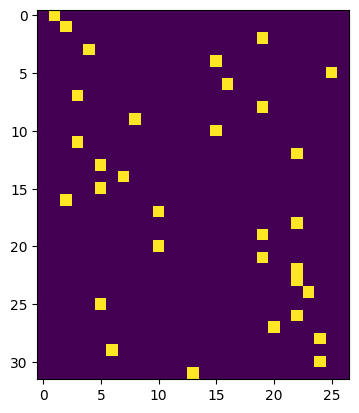

In [49]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])) # logits shape 1 is 27. This basically just makes a 32, 27 array, with each row having 0s and a 1 in the position of the correct index
print(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]).shape)

### Logits and h, W2, b2

In [54]:
logits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [66]:
dlogits @ W2.T

tensor([[-1.3317e-03, -4.8336e-03,  2.1100e-03,  ..., -2.0401e-03,
         -2.0078e-03, -1.9343e-03],
        [-2.8817e-03,  2.2771e-03, -1.7434e-03,  ...,  1.0092e-03,
         -3.1052e-03, -4.9481e-03],
        [-6.6450e-05,  5.3056e-03,  2.6279e-03,  ...,  7.2947e-03,
         -9.3339e-04,  1.0139e-03],
        ...,
        [-1.6354e-03,  2.5897e-03, -2.6171e-03,  ..., -4.3539e-03,
         -2.6826e-03, -3.5181e-03],
        [-3.5565e-03,  8.5893e-04, -5.0359e-03,  ...,  5.2263e-04,
          2.8454e-03,  5.1892e-03],
        [ 3.5356e-04,  5.3225e-03,  3.2453e-03,  ..., -2.0260e-03,
          3.2633e-03,  8.0382e-04]], grad_fn=<MmBackward0>)

#### hpreact

Right. So dL/dpreact. well, what'
h = tanh(x).
dh/dx ... Well. Local derivative of h (i.e dh/dhpreact) would just be derivative of tanh, i.e 1-tanh(x)**2. Lol
So it's just 1-itself**2 for every element in the thing. Cool! (This is the local derivative), i.e:
dh/dhpreact = 1 - h**2  !!! Yeah!!! Nice!

And then ofc dL/dhpreact = dh/dhpreact * dL/dh = (1-h**2) * dh 

#### bngain stuff etc
We can just use our cheats etc by looking at the shapes and how we know we derive matrix stuff from the video/paper hehhehhee.... || OH SHIT NEVERMIND -- it's a fucking elementwise multiply lmaooo ya gronk

So looks like (with help of below):
Local derivatives
dhpreact/dbngain = bnraw.sum(0) # because the element wise * broadcasted our bngain downwards (by row), so we're "colleccting" them again :) || Since element wise, we gotta (bnraw * dhpreact).sum(0) for it to pass through properly.

dhpreact/bnraw = (bngain * hpreact) # The bngain broadcasts back to what we want so it's chill

dhpreact/dbnbias = dhpreact.sum(0, keepdim=True) # sum the rows dimension, since our bnbias is being broadcasted that way (and thus we must 'collect' all the gradients that we attributed our element nodes to) || keepdim true because [1,64] for some reason.


In [111]:
print(f'{dhpreact.shape}, {bngain.shape}, {bnraw.shape}, {bnbias.shape}')

torch.Size([32, 64]), torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([1, 64])


In [112]:
hpreact.shape, bngain.T.shape # Gotta multiply this way to end well

(torch.Size([32, 64]), torch.Size([64, 1]))

#### bndiff, bnvar_inv
So... bitwise multiplication again,let's start with bnvar_inv
dbnraw/bnvar_inv = bndiff, but we do have to be careful with shapes and broadcasting

dbnraw/bnvar_inv = bndiff.sum(0, keepdim=True).shape #technically true
And for bndiff, it'll just be bnvar_inv but in the shape of bndiff (i.e copy bnvar_inv downwards)
So dL/dbnvar_inv = dbvar_inv = ^^ above * dbnraw  ## WELL, LOOK BELOW. YOU HAVE TO DO THE ELEMENT WISE * FIRST, AND THEN YOU CAN SUM THEM.

Wait so:
```
dbndiff = bnvar_inv * dbraw # this works since our broadcasting is fine
dbnvar_inv = (bndiff * dbraw).sum(0, keepdim=True)
```

In [16]:
dbnraw.shape, bndiff.shape, bnvar_inv.shape
# bnvar_inv is broadcasted all the way down (duplicate all the row vectors) to bndiff, so it's basically distributing all its elements over everything in bndiff.
# I.e, to get the derivative of bnvar_inv, it's not just bndiff, we also have to sum it up row wise (dim 0) to "collect" all our elements' gradients back. And we keepdims because it's bnvar_inv is [1,64] for some reason

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

#### dbnvar time, and then we dbndiff2
well, dl/dbnvar time. Local deriviative so dbnvar_inv / dbnvar: so the function is 1/sqrt(x+1e5)..
-0.5 *(x+1e5)**-1.5

Cool! NNow let's try dbnvar / dbndiff 2 which is the summy thingy

In [27]:
dbnvar = -0.5 *( bnvar+1e-5)**-1.5 # local derivative
dbnvar *= bnvar_inv

In [23]:
bnvar.shape
bndiff2.shape

torch.Size([32, 64])

In [42]:
print((bndiff2.sum(0, keepdim=True) / (n-1)).shape) #well, would the gradient just be 1/n-1? because like, say y=x. dy/dx = 1. duh. dbnvar/dbdiff2 = 1 for all elements if there wasn't the 1/(n-1) scaling. Pog!
print(bnvar.shape)
## lmao, it would!!!
print((torch.ones_like(bndiff2) * 1/(n-1)).shape) # Local derivaitve dbnvar/dbndiff2is just all 1/(n-1) because we're distributing that gradient over all the elements.
## And we get the full derivative (chain ruled) byu just multiplying -- broadcasting will do it the way we want to.
print(bndiff2.shape) # what we want our dnbiff2.shape to look like (since well, yeah... we want the shapes of the gradient tensor to be the same as the bloody numbers we're doing it on)

torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([32, 64])
torch.Size([32, 64])


In [ ]:
# While we're att it, dbndiff2 / dbndiff = 2bndiff. yay! :D 
# second part of dbndiff done. that's dnbdiff done! YOOOOO IT WORKS!!!!!!
# so we dbndiff += 2bndiff * dbndiff2, as the first part was calculated before.

#### From bndiff= hprebn - bnmeani

Let's do dbndiff / dbnmeani:

In [47]:
bndiff.shape, hprebn.shape, bnmeani.shape
## Hohoohho so bnmeani gets broadcasted in the forward pass.. hmmm.... I wonder if 
# OH MY GOOOOD!!! we have to sum it in the backwards pass wahaaaaat to 'collect' our distributed gradients that are attached to the elements of bnmeani

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [58]:
dhprebn = 1* dbndiff.clone() # same shape, so we just 'pass the gradients' like that. || This is our dL/dhprebn. dbndiff/dhprebn = 1. Ofc this isn't the full dL/dhprebn
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)# local gradient of -1 since it's just ... - bnmeani, and then we sum our output gradients back in order to 'collect' the broadcasted elements back again. Can be simplified to -dbndiff.sum(0).

torch.Size([1, 64])

#### Hprebn etc... 

hprebn = embcat @ W1 + b1 # hidden layer pre-activation. Basically just the same as layer 2 stuff.

In [16]:
print('layer 2 shapes from before: ', dlogits.shape, h.shape, W2.shape, b2.shape)
print('layer 1: ', hprebn.shape, dhprebn.shape, embcat.shape, W1.shape, b1.shape)
# Yep, just same stuff as before.
# Make sure the shapes fit well soo like it'd be
# dembcat = dphrebn * W1.T -> (32, 64) * (64, 30)
print(dh.shape)

layer 2 shapes from before:  torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])
layer 1:  torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])
torch.Size([32, 64])


In [20]:
##### Forward pass: embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
print(embcat.shape, emb.shape)
# Really, all we did was flatten the 3rd dimension into the 2nd one, yknow?
# View just interprets the way the array is arranged lol so we can put it back to its normal shape.
demb = dembcat.view(emb.shape) # can pass tuples into views :o 
demb.shape

torch.Size([32, 30]) torch.Size([32, 3, 10])


torch.Size([32, 3, 10])

In [35]:
# emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
# So basically, we're only selecting whatever C elements are in Xb
# Xb is 32 examples of indices like [1,1,4], [2,3,1] .... And then, these indices are looked up in our C embedding, which is where we embedded all our vocab (alphabet) into some 10 dimensional vector.
print(Xb[:5])
## And remember, now we have demb. We have their gradients.
# So we just have to route back those gradients into whichever row/element of C they came from!

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [45]:
demb[0, 0] # This is the encoding (embedding) for a '., .'

tensor([ 4.3405e-04, -1.5912e-03, -5.3613e-06,  2.1225e-03, -1.7826e-03,
        -2.8640e-03,  4.1290e-03,  5.9210e-04, -6.2336e-04,  1.1974e-03],
       grad_fn=<SelectBackward0>)

In [46]:
dC = torch.zeros_like(C)
# For every element in the Xb (which is like the indices stuff -- [1,1,4], ...)
for k in range(Xb.shape[0]):
	for j in range(Xb.shape[1]):
		ix = Xb[k,j] # the value; the alphabet position index (e.g 1 -> a)
		print(ix, k,j, demb[k,j].shape) ## Prints size 10. I.e, this is the vector embedding. Well, this is the GRADIENT of the vector embedding!!!
		dC[ix] += demb[k, j] # We add the GRADIENT of the embedding vector

tensor(1) 0 0 torch.Size([10])
tensor(1) 0 1 torch.Size([10])
tensor(4) 0 2 torch.Size([10])
tensor(18) 1 0 torch.Size([10])
tensor(14) 1 1 torch.Size([10])
tensor(1) 1 2 torch.Size([10])
tensor(11) 2 0 torch.Size([10])
tensor(5) 2 1 torch.Size([10])
tensor(9) 2 2 torch.Size([10])
tensor(0) 3 0 torch.Size([10])
tensor(0) 3 1 torch.Size([10])
tensor(1) 3 2 torch.Size([10])
tensor(12) 4 0 torch.Size([10])
tensor(15) 4 1 torch.Size([10])
tensor(14) 4 2 torch.Size([10])
tensor(0) 5 0 torch.Size([10])
tensor(17) 5 1 torch.Size([10])
tensor(1) 5 2 torch.Size([10])
tensor(0) 6 0 torch.Size([10])
tensor(0) 6 1 torch.Size([10])
tensor(13) 6 2 torch.Size([10])
tensor(13) 7 0 torch.Size([10])
tensor(13) 7 1 torch.Size([10])
tensor(1) 7 2 torch.Size([10])
tensor(8) 8 0 torch.Size([10])
tensor(25) 8 1 torch.Size([10])
tensor(12) 8 2 torch.Size([10])
tensor(0) 9 0 torch.Size([10])
tensor(0) 9 1 torch.Size([10])
tensor(26) 9 2 torch.Size([10])
tensor(22) 10 0 torch.Size([10])
tensor(15) 10 1 torch.Si

In [12]:
# Exercise 1: backprop through the whole thing manually, || lots of explaining code above for our things
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
## Ahh I got why I kept getting a bit 'wait is this right..' because I'm typing dlogprobs etc.. instead of dL/dlogprobs first, so I'm like uhhhh
# Say we have L = 3xy
# dL/dx = 3y. So in our notation, that'd be dx = 3y, yeah?
# There we go. It should be good now. Basically, when we're trying to find 'dx', that's really dL/dx = ... so it's good.

### I.e when we write dh, really we mean dL/dh, or dldh, but we don't write the dl because words... but still it's so aaaaaahhh chungy
# Alll ouur derivatives w.r.t loss
dlogprobs = torch.zeros_like(logprobs) # makes zeros matrix same shape as logprobs
dlogprobs[range(n), Yb] = -1.0/n # derivative of Loss w.r.t logprobs

dprobs = (1.0/probs) * dlogprobs # Local derivative * outer gradient. Intuitively, it's making any examples wiht low probabilities assigned, and boosting t heir gradient || this be dLoss/dprobs 

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # Horizontal sum of local derivative (counts) and output derivative/gradient (dprobs), sum along because that's how you add gradients for multiple nodes || Really good explanation written for this working in my dlogit_maxes working out above!!!!
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += (torch.ones_like(counts)* dcounts_sum) # this part is the counts_sum section, etc... Basically the summing acts like a router of the inflowing gradient

dnorm_logits = counts *dcounts # Local derivative 
dlogits = 1 * dnorm_logits.clone() # for safety :o. Also, this isn't the final dlogits!
dlogit_maxes = - 1 * dnorm_logits.sum(1, keepdim=True) # Funny thing, this is basically all 0s right, because all this is doing is stabilising our logits so that they're all <=0, so we can .exp() without overflowing anything. And you can see, that all the gradients here are basically 0, reflecting the fact that changing these logit values doesnt change the loss (and also the probs).
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # lgoit maxes is (32,1), and look at the logits section. This basically routes the correct logit max to wherever it needs to go

# Now onto our layers -- did some math on paper -- see video
dh = dlogits @ W2.T # dL/dh = dL/dlogits * W2 transpose || (32, 27) * (27, 64) -> (32, 64) == h.shape
dW2 =  h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h **2) * dh

# ## Bnbias part
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # Since all this is element wise *, yo! || Keeping keepdim on because we initialised as [1,64] and not just [64] for whatever reason (he said idk why lmao)
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdim=True) # keepdim bc [1,64] for some reason again
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw # broadcasting fixes it for us. But this isn't it; bndiff is used many times || remember, dL/dbndiff
dbnvar = (-0.5 *( bnvar+1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (torch.ones_like(bndiff2) * 1/(n-1)) * dbnvar

dbndiff += 2*bndiff * dbndiff2 # second part of (dL/)bndiff
"""Ahaha, notice how:
when we have a sum in the forward pass, it ends up being a replication/broadcasting thing in the backwards (to 'distribute' our gradients').
Conversely, when we have a replication/broadcast in the forward pass, we end up summing in the backwards pass (to 'collect' our gradients). Pog. """
dhprebn = 1 * dbndiff.clone() # same shape, so we just 'pass the gradients' like that. || This is our dL/dhprebn. dbndiff/dhprebn = 1
dbnmeani = (-dbndiff).sum(0) # local gradient of -1 since it's just ... - bnmeani, and then we sum our output gradients back in order to 'collect' the broadcasted elements back again.
dhprebn +=  1.0/n *( torch.ones_like(hprebn) * dbnmeani) # dl/dhprebn

## layer 1 shit
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn # || Need to end up with (30, 64) W1.shape. So do that by embcat.T (30, 32) @ (32, 64) dhprebn. ez. 
db1 = 1 * dhprebn.sum(0) # || Remember, this is broadcasted aswell. So local derivative is just 1 since it's addition. But, we have to sum the rows because that's how the broadcasted distributed the b1 vector, so now we 'collect' those nodes again.

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
# For every element in the Xb (which is like the indices stuff -- [1,1,4], ...)
for k in range(Xb.shape[0]):
	for j in range(Xb.shape[1]):
		ix = Xb[k,j] # the value; the alphabet position index (e.g 1 -> a)
		# print(ix, k,j, demb[k,j].shape) 
		dC[ix] += demb[k, j] 


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [15]:
logprobs[1, 1] # For example 1, collect the first character.
# For our deriving, probs[y] is just a single value; the probability of choosing the correct character index.

tensor(-2.8247, grad_fn=<SelectBackward0>)

In [23]:
print(Yb.shape, probs.shape) # 32 examples, each example 27 probs (referring to probability of that char being chosen)
print(probs[Yb].sum()) # because 32 examples
print(probs[0].sum())

## Basically, dlogits: dloss/dlogits = P_i if i !=y, and P_i - 1 if i=y
# other places have it like p_i - y_i (basically, y would be a vector of all 0s except for one 1). This would be for an individual example. P_i is the probability distribution of that i'th element.

## What it's saying is that, the logits 
print("logits!!", logits.shape, logits[0], logits[0].sum())

torch.Size([32]) torch.Size([32, 27])
tensor(32., grad_fn=<SumBackward0>)
tensor(1., grad_fn=<SumBackward0>)
logits!! torch.Size([32, 27]) tensor([ 8.1234e-01,  9.7460e-01, -4.9720e-01,  4.2870e-01, -3.9033e-01,
         9.8613e-01, -3.8532e-01,  7.1250e-02, -6.9734e-01,  5.1466e-04,
         2.9390e-01,  7.6986e-02,  1.6035e-01, -1.5084e-01,  1.2482e-01,
        -7.9750e-01, -1.3046e+00, -4.6557e-01, -7.3601e-01,  4.7255e-01,
         5.0036e-01, -2.7683e-01, -2.7102e-01,  8.0077e-01,  6.4866e-01,
        -7.3495e-02, -4.2614e-01], grad_fn=<SelectBackward0>) tensor(-0.1203, grad_fn=<SumBackward0>)


In [26]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1) # softmax converts logits -> prob distrs. 
# Softmax row wise ofc, because the row is our 27 chars possibilities.
# ^ Above sets all dloss/dlogits to P_i.
dlogits[range(n), Yb] -= 1 # Do the P_i - 1 bit for the correct character, for every training example in the batch (n=32 here)
dlogits /= n # Loss is average loss, so we need to scale down gradients by the mean thingy.

# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


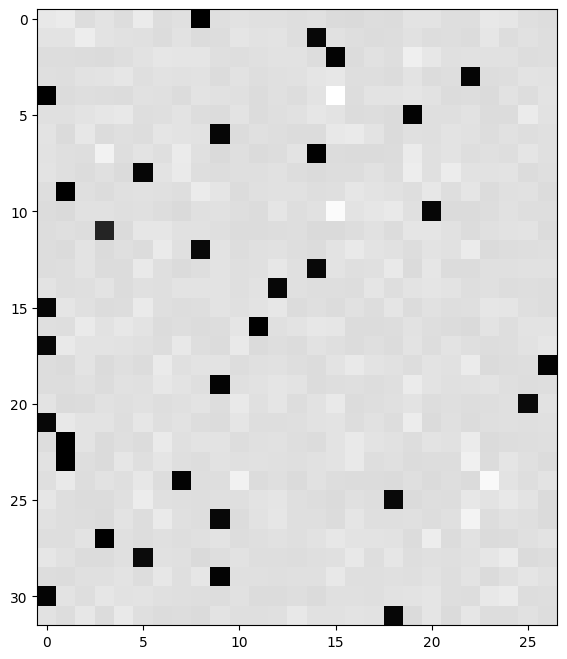

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')
# Black squares are the positions of the correct indices, where we
# did the -1 on dlogits.

In [33]:
# Let's look at the first row for probability
F.softmax(logits, 1)[0]  # prob distr of row 1 for logits

tensor([0.0714, 0.0839, 0.0193, 0.0486, 0.0214, 0.0849, 0.0215, 0.0340, 0.0158,
        0.0317, 0.0425, 0.0342, 0.0372, 0.0272, 0.0359, 0.0143, 0.0086, 0.0199,
        0.0152, 0.0508, 0.0522, 0.0240, 0.0242, 0.0705, 0.0606, 0.0294, 0.0207],
       grad_fn=<SelectBackward0>)

In [43]:
print(dlogits[0] * n)# Bringing it back up from the mean to its original values || See how we got dlogits lmao || (i.e just the probabilities once again, but with our -1 here!)
# ^^ Is just so it's easier to interpret for us.
print(dlogits[0].sum()) # sums to 0 

tensor([ 0.0714,  0.0839,  0.0193,  0.0486,  0.0214,  0.0849,  0.0215,  0.0340,
        -0.9842,  0.0317,  0.0425,  0.0342,  0.0372,  0.0272,  0.0359,  0.0143,
         0.0086,  0.0199,  0.0152,  0.0508,  0.0522,  0.0240,  0.0242,  0.0705,
         0.0606,  0.0294,  0.0207], grad_fn=<MulBackward0>)
tensor(1.6298e-09, grad_fn=<SumBackward0>)


Do you see how everything is the same between the actual prob distribution and the dlogits, except for the -1 at the correct char index?

And the sum of dlogits' rows like dlogits[0].sum() == 0. Woah!! It's like a force; you're pulling down on the probabiltities that aren't correct, and tugging up the probability that is correct. And it's like some sort of fabric.

Like, the probs that are wrong, but with high values, will end up going *down* a lot more (since their P_i is also high and thus so is their gradient), whilst those with low probabilties won't go down too much. And the one with the right probability should go up more.

And the amount of total push/pull is equalised since our sum is 0!! I.e, the amount that our good probability goes up == sum of all the bad probabilities going down! It 'takes' from the other ones.

In [10]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [28]:
hprebn.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [31]:
a = torch.tensor([[1,2,3],[1,2,3]])
a
a.sum(1)

tensor([6, 6])

In [36]:
dhpreact.shape
## OOooooh, I get why it's sum(0) and not column wise.
# okay, so dl/dy == dhpreact, yep, and that's (32,64).

# Now for the summation -sum(dl/dy_j for j=1 to m), we're summing to the number of training examples, you see? m = num training examples = n in the code here. But on our paper, yeah.
# So we're actually summing by row here, so we want dhpreact.sum(0), as that's 
# == sum_j=1 to m( dl/dy_j)

torch.Size([32, 64])

In [43]:
bnraw.shape, dhpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [41]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# dl/dy is dhpreact.
cons1 = bngain * bnvar_inv / n
firstseg = -dhpreact.sum(0)
secseg = -n/(n-1) * bnraw * (bnraw * dhpreact).sum(0)
thirdseg = n * dhpreact

dhprebn = cons1 *(firstseg + secseg + thirdseg) ## Nice. That's it.
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [73]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 20000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO). Since, we aren't gonna call .backward() on anything... since we IMPLEMENTED IT BY HAND!!
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        #   loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)
        # Get to dloss/dlogits
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1 
        dlogits /= n
        # backprop through second layer
        dh = dlogits @ W2.T 
        dW2 =  h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1 - h **2) * dh
        
        
        ### Backproping through batchnorm:
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # Want to update
        dbnbias = dhpreact.sum(0, keepdim=True) # Want to update
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) # One lined it. || Speedrun to the preactivation (i.e skip all intermediary backpropping through batchnorm)

        # Backpropping through layer 1
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = 1 * dhprebn.sum(0)

        # Backprop and get gradient for our C embedding matrix
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k, j] 

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias] # These are all the gradients we actually care about; the things we will actually update. All the other shit is basically just intermediary stuff.
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 5000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        # print(i)
        #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
        #     break
## output of this cell a bit different because I changed it a bit, but yeah. Should be fine to run it again: No loss.backward() required HOOOOLY custom implementation achieved. ez backprop.

12297
      0/   3000: 3.8234


In [72]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)
  # Perfect. Tiny ass differences, they're basically the same thing lol. We've done it right!

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [65]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [70]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2129976749420166
val 2.229011297225952


In [67]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145
# || He used 200k steps though @.@

In [69]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ambelleigh.
mri.
reety.
salansa.
jazonto.
amerynt.
kaeli.
ner.
kentce.
ihvon.
leigh.
ham.
join.
quinn.
saline.
kaidel.
wantho.
dearixi.
jace.
